# Fine Tuning GoldFish

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip -q install transformers datasets accelerate evaluate sentencepiece


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.0 MB/s eta 0:00:00


In [ ]:
DATA_PATH = "/content/sample_data/cleaned-general-text.txt"

In [ ]:
with open(DATA_PATH, "r", encoding="utf-8") as f:
    for i in range(3):
        print(repr(f.readline().strip()))


'សាលារាជធានីថាមិនទាន់ទទួលបានលិខិតសុំធ្វើបាតុកម្មរបស់ក្រុមសម្ព័ន្ធយុវជនគាំទ្រគណបក្សប្រជាជននៅឡើយ'
'ភ្នំពេញសាលារាជធានីភ្នំពេញនៅមិនទាន់ទទួលបានលិខិតជាផ្លូវការណាមួយដើម្បីស្នើធ្វើបាតុកម្មពីក្រុមសម្ព័ន្ធយុវជនគាំទ្រគណបក្សប្រជាជនកម្ពុជាដើម្បីប្រឆាំងនឹងគណបក្សសង្រ្គោះជាតិនៅឡើយទេ'
'នេះបើតាមលោកឡុងឌីម៉ង់អ្នកនាំពាក្យសាលារាជធានីភ្នំពេញបានថ្លែងប្រាប់នៅព្រឹកថ្ងៃចន្ទនេះ'


Load as a Hugging Face Dataset

In [ ]:
from datasets import load_dataset

raw = load_dataset("text", data_files={"data": DATA_PATH})
raw


Generating data split: 0 examples [00:00, ? examples/s]

DatasetDict({
    data: Dataset({
        features: ['text'],
        num_rows: 305653
    })
})

Split 80/10/10 (train/val/test)

In [ ]:
seed = 42
tmp = raw["data"].train_test_split(test_size=0.10, seed=seed)  # 90% / 10%
train_val = tmp["train"].train_test_split(test_size=0.1111111111, seed=seed)
# 0.1111 of 90% = 10% of total

ds = {
    "train": train_val["train"],   # 80%
    "validation": train_val["test"],# 10%
    "test": tmp["test"]            # 10%
}

ds["train"], ds["validation"], ds["test"]


(Dataset({
     features: ['text'],
     num_rows: 244521
 }),
 Dataset({
     features: ['text'],
     num_rows: 30566
 }),
 Dataset({
     features: ['text'],
     num_rows: 30566
 }))

Load tokenizer + model

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "goldfish-models/khm_khmr_5mb"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(model_name)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/573 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/850 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/157M [00:00<?, ?B/s]

In [ ]:
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.eos_token_id


Tokenization

In [ ]:
def tok_fn(batch):
    return tokenizer(batch["text"], add_special_tokens=True)

tok = {}
for split in ds:
    tok[split] = ds[split].map(tok_fn, batched=True, remove_columns=["text"])


Map:   0%|          | 0/244521 [00:00<?, ? examples/s]

Map:   0%|          | 0/30566 [00:00<?, ? examples/s]

Map:   0%|          | 0/30566 [00:00<?, ? examples/s]

Group into blocks

In [ ]:
block_size = 256

def group_texts(examples):
    # Concatenate
    concatenated = {k: sum(examples[k], []) for k in examples.keys()}
    total_len = len(concatenated["input_ids"])
    # Drop remainder
    total_len = (total_len // block_size) * block_size
    result = {
        k: [t[i:i+block_size] for i in range(0, total_len, block_size)]
        for k, t in concatenated.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

lm = {}
for split in tok:
    lm[split] = tok[split].map(group_texts, batched=True)


Map:   0%|          | 0/244521 [00:00<?, ? examples/s]

Map:   0%|          | 0/30566 [00:00<?, ? examples/s]

Map:   0%|          | 0/30566 [00:00<?, ? examples/s]

Data collator (causal LM)

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # IMPORTANT: causal LM, not masked LM
)


Metrics: CE loss, perplexity, and Top-5 accuracy

In [ ]:
import torch
import numpy as np
from transformers import EvalPrediction

TOP_K = 5

def preprocess_logits_for_metrics(logits, labels):
    # logits can be a tuple
    if isinstance(logits, tuple):
        logits = logits[0]
    # Keep ONLY top-5 indices -> (bs, seq, 5)
    topk = torch.topk(logits, k=TOP_K, dim=-1).indices
    return topk

def compute_metrics(eval_pred: EvalPrediction):
    topk_ids, labels = eval_pred.predictions, eval_pred.label_ids

    # Shift for next-token prediction
    topk_ids = topk_ids[:, :-1, :]   # predictions at position t
    labels = labels[:, 1:]           # true token at position t+1

    mask = labels != -100
    labels_masked = labels[mask]     # (N,)
    topk_masked = topk_ids[mask]     # (N, 5)

    top5 = (topk_masked == labels_masked[:, None]).any(axis=1).mean()
    return {"top5_acc": float(top5)}


Training configuration

In [ ]:
from transformers import TrainingArguments, Trainer

out_dir = "/content/drive/MyDrive/khm_khmr_5mb_finetuned"


from transformers import TrainingArguments

args = TrainingArguments(
    output_dir=out_dir,
    num_train_epochs=50,
    learning_rate=5e-5,

    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,   # effective 16
    per_device_eval_batch_size=2,    # reduce eval peak mem
    eval_accumulation_steps=8,       # flush to CPU periodically

    fp16=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    report_to="none",
)



create trainer

In [ ]:
model.gradient_checkpointing_enable()
model.config.use_cache = False

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=lm["train"],
    eval_dataset=lm["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
)


/tmp/ipython-input-480608275.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
train_result = trainer.train()


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss,Top5 Acc
1,6.359700,6.256940,0.242774
2,5.993900,5.939907,0.274241
3,5.742400,5.733956,0.296059
4,5.572400,5.589808,0.312030
5,5.426700,5.471002,0.324947
6,5.307800,5.372260,0.336041
7,5.190700,5.298511,0.345169
8,5.096100,5.231578,0.352857
9,5.005800,5.175701,0.360242
10,4.942500,5.127455,0.365838


Epoch,Training Loss,Validation Loss,Top5 Acc
1,6.359700,6.256940,0.242774
2,5.993900,5.939907,0.274241
3,5.742400,5.733956,0.296059
4,5.572400,5.589808,0.312030
5,5.426700,5.471002,0.324947
6,5.307800,5.372260,0.336041
7,5.190700,5.298511,0.345169
8,5.096100,5.231578,0.352857
9,5.005800,5.175701,0.360242
10,4.942500,5.127455,0.365838


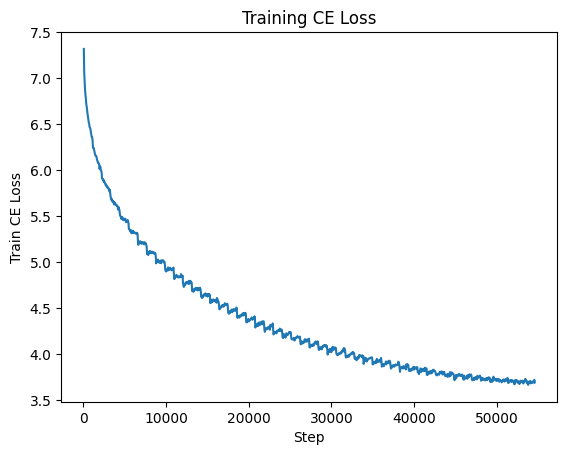

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math

logs = pd.DataFrame(trainer.state.log_history)

# Training loss points
train_logs = logs[logs["loss"].notna()][["step", "loss"]].copy()

# Eval points (per epoch)
eval_logs = logs[logs["eval_loss"].notna()][["epoch", "eval_loss", "eval_top5_acc"]].copy()
eval_logs["perplexity"] = eval_logs["eval_loss"].apply(lambda x: math.exp(x))

# 1) CE loss curve (train)
plt.figure()
plt.plot(train_logs["step"], train_logs["loss"])
plt.xlabel("Step")
plt.ylabel("Train CE Loss")
plt.title("Training CE Loss")
plt.show()




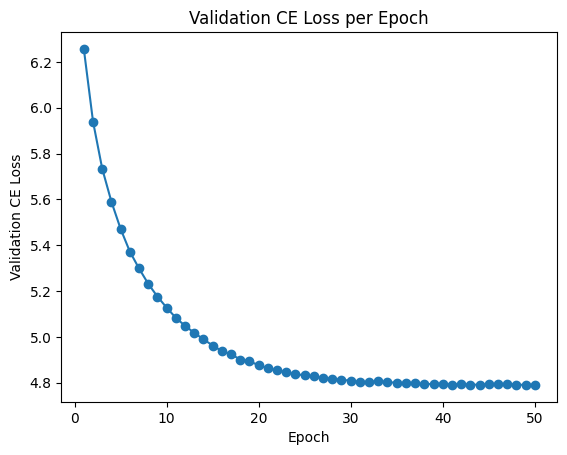

In [ ]:
# 2) Validation CE loss
plt.figure()
plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation CE Loss")
plt.title("Validation CE Loss per Epoch")
plt.show()



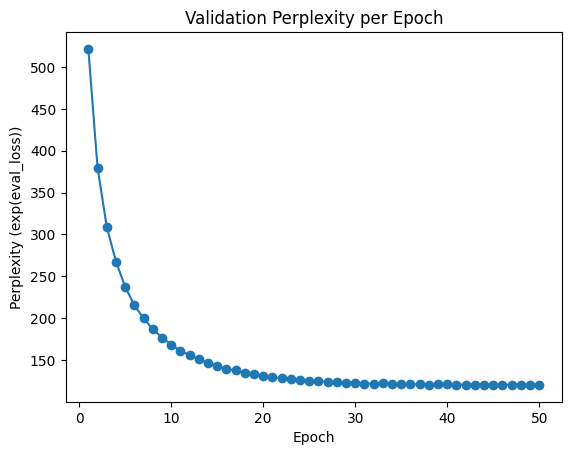

In [ ]:
# 3) Perplexity
plt.figure()
plt.plot(eval_logs["epoch"], eval_logs["perplexity"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Perplexity (exp(eval_loss))")
plt.title("Validation Perplexity per Epoch")
plt.show()



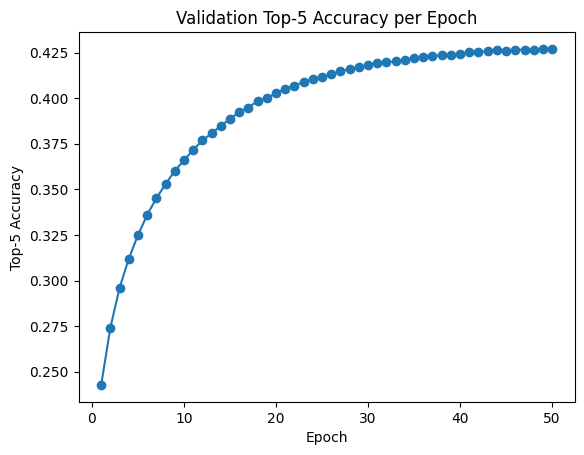

In [ ]:
# 4) Top-5 accuracy
plt.figure()
plt.plot(eval_logs["epoch"], eval_logs["eval_top5_acc"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Top-5 Accuracy")
plt.title("Validation Top-5 Accuracy per Epoch")
plt.show()

In [ ]:
trainer.save_model(out_dir)         # saves model + config
tokenizer.save_pretrained(out_dir)  # saves tokenizer files


('/content/drive/MyDrive/khm_khmr_5mb_finetuned/tokenizer_config.json',
 '/content/drive/MyDrive/khm_khmr_5mb_finetuned/special_tokens_map.json',
 '/content/drive/MyDrive/khm_khmr_5mb_finetuned/spiece.model',
 '/content/drive/MyDrive/khm_khmr_5mb_finetuned/added_tokens.json',
 '/content/drive/MyDrive/khm_khmr_5mb_finetuned/tokenizer.json')

In [ ]:
SAVE_DIR = "/content/drive/MyDrive/khm_khmr_5mb_finetuned"

trainer.save_model(SAVE_DIR)      # saves model + config
tokenizer.save_pretrained(SAVE_DIR)  # saves tokenizer


('/content/drive/MyDrive/khm_khmr_5mb_finetuned/tokenizer_config.json',
 '/content/drive/MyDrive/khm_khmr_5mb_finetuned/special_tokens_map.json',
 '/content/drive/MyDrive/khm_khmr_5mb_finetuned/spiece.model',
 '/content/drive/MyDrive/khm_khmr_5mb_finetuned/added_tokens.json',
 '/content/drive/MyDrive/khm_khmr_5mb_finetuned/tokenizer.json')

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_PATH = "/content/drive/MyDrive/khm_khmr_5mb_finetuned"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForCausalLM.from_pretrained(MODEL_PATH)

print("Model & tokenizer loaded successfully!")


Model & tokenizer loaded successfully!


In [ ]:
inputs = tokenizer("នេះគឺ", return_tensors="pt")

outputs = model.generate(
    **inputs,
    max_length=60,
    do_sample=True,
    top_k=50,
    top_p=0.95,
)

print(tokenizer.decode(outputs[0], skip_special_tokens=True))


នេះគឺ ឃុំអូរស្វាយនេះមានភូមិ
